# Part 3 - Modelling quick surface runoff

Now that the hydrographs (Part 1) and rainfall input time series (Part 2) are prepared, this notebook demonstrates how the quick surface runoff for the subbasins is modelled. Because of the model restrictions we exclude subbasins with an area larger than 750 km².

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import counterfactual_discharge_analysis as cda

The quick runoff is modelled by superposition of the hydrographs of the individual basins. All this happens in the class `Event` in the script `counterfactual_discharge_analysis`. 
The process is as follows:
1. The effective rainfall gets multiplied with the hydrograph of a subbasin. We do this for every timestep and then sum up the results (superposition). This procdure is repeated for every subbasin.
2. For the subbasins which are not headwater catchments (order 1) we then add the hydrographs of the inflow basins to the subbasins hydrograph with the appropriate temporal delay. The temporal delay is determined by the traveltime rasters of the inflow basin and the recieving basin. The tree-like structure of the stream network and order of inflow basins was prepared in the notebook "Part 1 - Hydrographs from DEM". This iterative process starts with subbasins which just receive inflow from headwater catchments (order 2) and then traverses down the tree structure of the river network.
 

In [ ]:
subbasins = gpd.read_file('output/gis/subbasins_info.gpkg')
subbasins = subbasins.loc[subbasins.cum_upstream_area < 750, :]
subbasin_list = subbasins.sub_id.to_list()
subbasin_list.append(-999)
nw_jul21 = xr.open_dataset('input/nw_jul21.nc')
if not os.path.exists('output/analysis'):
    os.mkdir('output/analysis')

if not os.path.exists('output/analysis/nw_jul21'):
    os.mkdir('output/analysis/nw_jul21')

for id in subbasin_list:
    print(f'Event {id}')
    event = cda.Event("nw_jul21", id, event_ncdf=nw_jul21)
    event.discharge.to_csv(f'output/discharge/nw_jul21/dis_sub{id}.gz', compression='gzip', index=False) #Todo uncomment again
    event.analysis_df.to_csv(f'output/analysis/nw_jul21/analysis_sub{id}.gz', compression='gzip', index=False)

The ```Event```-class describes a rainfall event. It reads the previously computed precipitation and effective rainfall time series, the gis data and computes the discharge for each subbasin by using the respective hydrographs. Additionally, some analysis on the peak is computed:

- *sub_id*: ID of the subbasin
- *peak_m3/s*: The quick runoff peak [m³/s]
- *upstream_basin_area*: The cumulated area of the basin and all its upstream basins
- *UPD*: The unit peak discharge (UPD) is computed by the peak [m³/s] divided by the upstream basin area with an exponential correction factor of 0.6 according to  Gaume et al. (2008).
- *total_rain*: The total rainfall [mm] that the basin received during the event
- *1h_rain_max*: The maximum hourly rainfall [mm/h] that occured in the basin during the event
- *order**: The Strahler order of the basin. 1 describes a headwater basin. Larger numbers describe downstream basins.

Here are the results for the original NW/Jul21 event:

In [3]:
analysis_orginal_event = pd.read_csv("output/analysis/nw_jul21/analysis_sub19.gz")
analysis_orginal_event

,sub_id,peak_m3/s,upstream_basin_area,UPD,total_rain,1h_max_rain,order
0,1,10.4,9.3,2.7,45.5,13.3,1.0
1,2,12.0,14.7,2.4,46.3,10.8,1.0
2,3,15.6,8.2,4.4,54.4,17.2,1.0
3,4,15.1,9.0,4.0,49.9,15.5,1.0
4,5,44.2,23.8,6.6,55.2,18.8,1.0
5,6,18.0,7.9,5.2,52.8,18.5,1.0
6,7,33.1,19.0,5.7,61.4,15.1,1.0
7,8,65.9,15.5,12.7,80.2,22.5,1.0
8,9,123.6,36.8,14.2,77.9,21.6,1.0
9,10,90.6,35.5,10.6,67.7,18.4,1.0


The ```Event```-class can return all upstream basins for any given basin. In Case Study 1 we looked at the Altenahr basin. The town of Altenahr is in the basin with the ID 41. We can find all upstream basins with the Event-class.  Because we restricted the maximum basin size to 750 km² we need to remove the Vischelbach-catchment (ID:36) and catchment 41 from that list:

In [4]:
event = cda.Event("nw_jul21", -999, event_ncdf=None)
upstream_basins = event.get_upstream_basins(40).sub_id.to_list()
upstream_basins.remove('40') #we just want everything upstream
upstream_basins.remove('35') #remove Vischelbach catchment to stay in size restriction

Calculating discharge


Because we restricted the maximum basin size to 750 km² we used an outlet point before the inflowing Vischelbach and before the Ahr enters Altenahr:
light blue: Altenahr catchment of Case Study 1 with its outlet (red), black: subcatchment borders, blue: river network.

<Axes: >

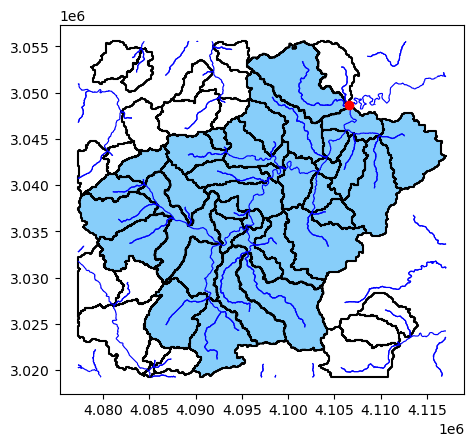

In [5]:
upstream_basins_int = [int(i) for i in upstream_basins]
altenahr_catchment = event.main_basin_shape.loc[event.main_basin_shape.sub_id.isin(upstream_basins_int), :]
outlet = gpd.read_file('input/outlet_altenahr.gpkg')
streams = gpd.read_file('input/streams.gpkg')

fig, ax = plt.subplots()
event.main_basin_shape.boundary.plot(facecolor=None, ax=ax, edgecolor="black")
altenahr_catchment.plot(facecolor="lightskyblue", ax=ax)
streams.plot(ax=ax, color="blue", linewidth=0.8)
outlet.plot(color="red", ax=ax, zorder=2)

The discharge and the rainfall for every subbasin can be plotted with the method ```plot_dis_and_rain```:

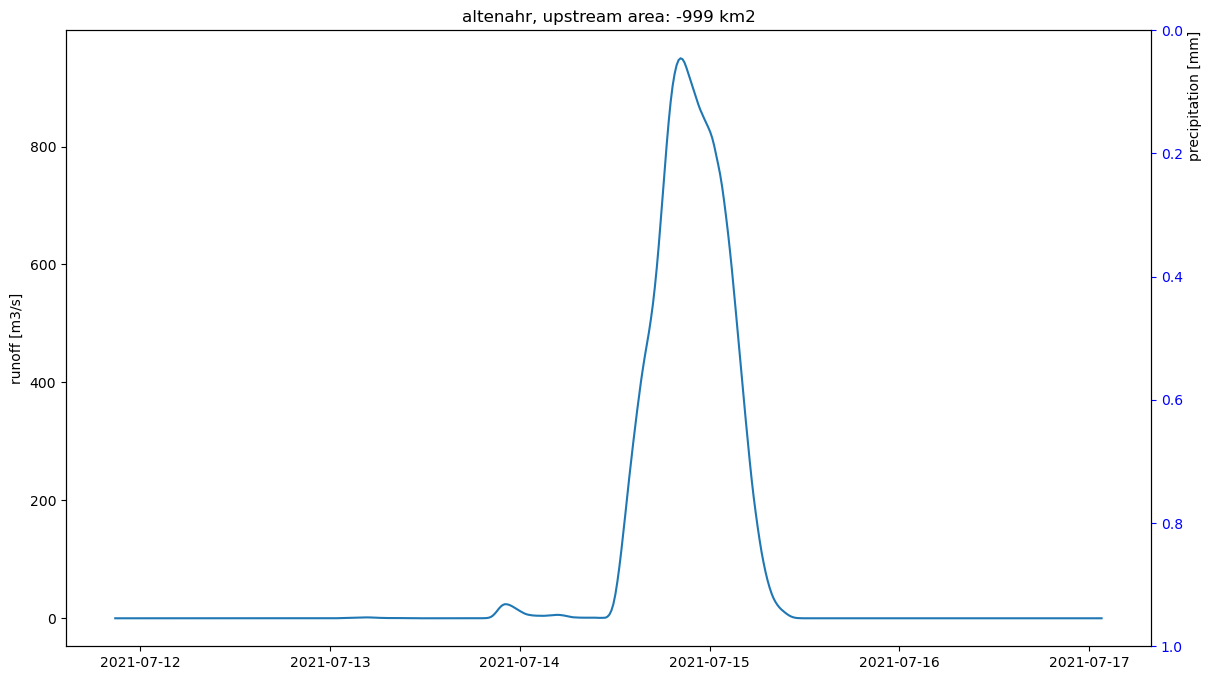

In [6]:
event.plot_dis_and_rain("altenahr")

## Counterfactual analysis
If we take the results from all the counterfactuals, we can see if any counterfactual would have caused a higher peak at the Altenahr outlet:

In [7]:
subbasins = gpd.read_file('output/gis/subbasins_info.gpkg')
subbasins = subbasins.loc[subbasins.cum_upstream_area < 750, :]
subbasin_list = subbasins.sub_id.to_list()
subbasin_list.append(-999)

counterfactuals = pd.DataFrame({'sub_id': subbasin_list, "peak_m3/s": 0.0})

for id in subbasin_list:
    df = pd.read_csv(f'output/analysis/nw_jul21/analysis_sub{id}.gz')
    peak = df.loc[df.sub_id == -999, "peak_m3/s"].item()
    counterfactuals.loc[df.sub_id == id, "peak_m3/s"] = peak

counterfactuals

,sub_id,peak_m3/s
0,1,605.6
1,2,591.9
2,3,567.1
3,4,511.4
4,5,478.9
5,6,538.7
6,7,456.4
7,8,718.6
8,9,700.9
9,10,721.7


The results show, that the event in the original position (ID: -999) produced the highest quick runoff peak (1002 m³/s). The counterfactual where the NW/Jul21 event was centered above the subbasin 41 produced the second highest peak with 762 m³/s. The lowest peak was for the counterfactual 32 with 389 m³/s. The counterfactuals alone have range of factor 1.96.